In [1]:
!pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=acf7da967b1059fad254995842582b4019282d3733f1eda6741681183b93fd5f
  Stored in directory: c:\users\user 1\appdata\local\pip\cache\wheels\df\88\9e\58ef1f74892fef590330ca0830b5b6d995ba29b44f977b3926
Successfully built pyspark


As per context given, we need to create a model that estimates whether prices quoted to clients in bonds are going to be accepted by them,
therefore resulting in a trade.

**Description of the dataset**:

**1. Dataset A: rfqs.csv:**

● date_time: date and time at which the quote is requested.

● Instrument: the bond for which the customer has requested a price

● client: client code (anonymized)

● price: price quoted to the client by the bank

● mid: market mid-price of the bond captured by the bank's system at the time of the operation

● vol_MM: amount requested by the client (in millions of euros).

● dv01: sensitivity of the bond to variations in its yield (a measure of risk of the bond)

● num_dealers: number of banks from whom the client has requested a quote

● side: 1 if it is buy -1 if it is sell (from the point of view of the bank, not the client)

● won: 0 if the bank did not close the operation, 1 if it did.


**2. Dataset B mids.csv:**

● date_time: day and time of the market mid-price of the bond

● mid: market mid-price of the bond provided by a data provider with greater reliability than our platform, sampled with a frequency of 5 minutes

● instrument: the bond for which the market price is provided



**Importing Dataset**

In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import to_date
from pyspark.sql.functions  import date_format
import pyspark.sql.functions as F
from pyspark.sql.functions import coalesce
from pyspark.sql.functions import when
from pyspark.sql.functions import year, month
from pyspark.sql.functions import to_date


from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression,\
                    RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# setting random seed for notebook reproducability
rnd_seed=1416
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

**Creating Spark Session**

In [4]:
spark = SparkSession.builder.master("local[2]").appName("BBVA-trading").getOrCreate()

In [5]:
spark

In [6]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=BBVA-trading>

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

**Loading dataset**

In [8]:
# 1. Loading mids dataset

mids_df = spark.read.csv('mids.csv',\
                     header=True, inferSchema=True)

In [9]:
mids_df.take(5)

[Row(_c0=0, date_time='2019-01-25 07:09:59', mid=107.758, instrument='H'),
 Row(_c0=1, date_time='2019-01-25 07:14:59', mid=107.757, instrument='H'),
 Row(_c0=2, date_time='2019-01-25 07:19:58', mid=107.755, instrument='H'),
 Row(_c0=3, date_time='2019-01-25 07:24:59', mid=107.756, instrument='H'),
 Row(_c0=4, date_time='2019-01-25 07:29:59', mid=125.28, instrument='K')]

In [10]:
mids_df.show(5)

+---+-------------------+-------+----------+
|_c0|          date_time|    mid|instrument|
+---+-------------------+-------+----------+
|  0|2019-01-25 07:09:59|107.758|         H|
|  1|2019-01-25 07:14:59|107.757|         H|
|  2|2019-01-25 07:19:58|107.755|         H|
|  3|2019-01-25 07:24:59|107.756|         H|
|  4|2019-01-25 07:29:59| 125.28|         K|
+---+-------------------+-------+----------+
only showing top 5 rows



In [11]:
# Lets print the schema to see datatypes of the columns
mids_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- date_time: string (nullable = true)
 |-- mid: double (nullable = true)
 |-- instrument: string (nullable = true)



The output of the show() might look ugly, especially if there are a large number of columns in the dataframe. At this point, we might miss Pandas head(). There is an option to convert the Spark dataframe into the Pandas dataframe. But we have to be careful here. Usually, Spark is handling a large volume of data, and converting it to Pandas stores everything immediately to the memory. Which we should avoid for the large data. However, there is a way out. Please remember the lazy evaluation of the Spark transformation. We can transform the Spark dataframe by limit(n) to take only n number of rows and then convert that to the Pandas. toPandas() is an action

In [12]:
mids_df.limit(5).toPandas()

,_c0,date_time,mid,instrument
0,0,2019-01-25 07:09:59,107.758,H
1,1,2019-01-25 07:14:59,107.757,H
2,2,2019-01-25 07:19:58,107.755,H
3,3,2019-01-25 07:24:59,107.756,H
4,4,2019-01-25 07:29:59,125.280,K


Alternatively we can select() a few columns and inspect within Spark. select() is an example of Spark transformation. Therefore that step is evaluated lazily. Hence we pass a Spark action show() at the end to print the result.

In [13]:
mids_df.select('mid','instrument').show(5)

+-------+----------+
|    mid|instrument|
+-------+----------+
|107.758|         H|
|107.757|         H|
|107.755|         H|
|107.756|         H|
| 125.28|         K|
+-------+----------+
only showing top 5 rows



In [14]:
mids_df.select('mid','instrument').summary().show()

+-------+------------------+----------+
|summary|               mid|instrument|
+-------+------------------+----------+
|  count|             23775|     23775|
|   mean|113.20981556256497|      null|
| stddev| 9.205682342637537|      null|
|    min|           100.471|         A|
|    25%|           106.864|      null|
|    50%|           111.036|      null|
|    75%|           117.494|      null|
|    max|           147.368|         L|
+-------+------------------+----------+



In [15]:
print('Number of rows: \t', mids_df.count())
print('Number of columns: \t', len(mids_df.columns))

Number of rows: 	 23775
Number of columns: 	 4


In [16]:
mids_df = mids_df.withColumn("DateOnly", date_format('date_time', "yyyy-MM-dd"))
mids_df.show(5)

+---+-------------------+-------+----------+----------+
|_c0|          date_time|    mid|instrument|  DateOnly|
+---+-------------------+-------+----------+----------+
|  0|2019-01-25 07:09:59|107.758|         H|2019-01-25|
|  1|2019-01-25 07:14:59|107.757|         H|2019-01-25|
|  2|2019-01-25 07:19:58|107.755|         H|2019-01-25|
|  3|2019-01-25 07:24:59|107.756|         H|2019-01-25|
|  4|2019-01-25 07:29:59| 125.28|         K|2019-01-25|
+---+-------------------+-------+----------+----------+
only showing top 5 rows



In [17]:
# Now let us load the rfqs dataset
rfqs_df = spark.read.csv('rfqs.csv',\
                     header=True, inferSchema=True)
print('Number of rows: \t', rfqs_df.count())
print('Number of columns: \t', len(rfqs_df.columns))

Number of rows: 	 6403
Number of columns: 	 11


In [18]:
rfqs_df.show(5)

+-----+--------------------+----------+------+-------+--------+------+-------+-----------+----+---+
|  _c0|           date_time|instrument|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|
+-----+--------------------+----------+------+-------+--------+------+-------+-----------+----+---+
|94075|2019-01-25 15:58:...|         I|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|
|94087|2019-01-28 09:28:...|         B|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|
|94089|2019-01-28 09:40:...|         F|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|
|94158|2019-01-29 16:21:...|         E|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|
|94194|2019-01-30 16:19:...|         F|     F|107.297| 107.217| 0.448|13.2087|          5|  -1|  0|
+-----+--------------------+----------+------+-------+--------+------+-------+-----------+----+---+
only showing top 5 rows



In [19]:
rfqs_df = rfqs_df.withColumn("DateOnly", date_format('date_time', "yyyy-MM-dd"))
rfqs_df.show(5)

+-----+--------------------+----------+------+-------+--------+------+-------+-----------+----+---+----------+
|  _c0|           date_time|instrument|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|  DateOnly|
+-----+--------------------+----------+------+-------+--------+------+-------+-----------+----+---+----------+
|94075|2019-01-25 15:58:...|         I|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|2019-01-25|
|94087|2019-01-28 09:28:...|         B|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|2019-01-28|
|94089|2019-01-28 09:40:...|         F|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|2019-01-28|
|94158|2019-01-29 16:21:...|         E|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|2019-01-29|
|94194|2019-01-30 16:19:...|         F|     F|107.297| 107.217| 0.448|13.2087|          5|  -1|  0|2019-01-30|
+-----+--------------------+----------+------+-------+--------+------+-------+-----------+----+---+----------+
o

**Cleaning and Treatment of data and feature engineering**

As I have taken date only format, I will be dropping the date-time and _c0 columns.

Not a great idea to drop time, as for model development accuracy it would be good to use time to pick mid value that maps with timing of our dataset's mid, but for now we will use highest value of mid for that day, which I will show below.

In [20]:
columns_to_drop = ['_c0','date_time']
rfqs_df = rfqs_df.drop(*columns_to_drop)
rfqs_df.show(5)

+----------+------+-------+--------+------+-------+-----------+----+---+----------+
|instrument|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|  DateOnly|
+----------+------+-------+--------+------+-------+-----------+----+---+----------+
|         I|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|2019-01-25|
|         B|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|2019-01-28|
|         F|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|2019-01-28|
|         E|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|2019-01-29|
|         F|     F|107.297| 107.217| 0.448|13.2087|          5|  -1|  0|2019-01-30|
+----------+------+-------+--------+------+-------+-----------+----+---+----------+
only showing top 5 rows



In [21]:
mids_df = mids_df.drop(*columns_to_drop)
mids_df.show(5)

+-------+----------+----------+
|    mid|instrument|  DateOnly|
+-------+----------+----------+
|107.758|         H|2019-01-25|
|107.757|         H|2019-01-25|
|107.755|         H|2019-01-25|
|107.756|         H|2019-01-25|
| 125.28|         K|2019-01-25|
+-------+----------+----------+
only showing top 5 rows



Here I will, groupby "instrument" and "DateOnly" columns and use that to find highest value of mid for that day

In [22]:
mids_max_df = (mids_df
    .groupBy("instrument", "DateOnly")
    .agg(F.max("mid").alias("mid_external")))
mids_max_df.show(5)

+----------+----------+------------+
|instrument|  DateOnly|mid_external|
+----------+----------+------------+
|         I|2019-01-29|     112.797|
|         A|2019-03-04|      101.95|
|         J|2019-03-05|      105.97|
|         G|2019-03-22|     104.703|
|         I|2019-10-03|     115.518|
+----------+----------+------------+
only showing top 5 rows



Let us see if that worked well or not, for that: I will mid value for "2019-01-25"

In [23]:
mids_df.filter("DateOnly like '2019-01-25' and instrument like 'H'").show()


+-------+----------+----------+
|    mid|instrument|  DateOnly|
+-------+----------+----------+
|107.758|         H|2019-01-25|
|107.757|         H|2019-01-25|
|107.755|         H|2019-01-25|
|107.756|         H|2019-01-25|
| 107.81|         H|2019-01-25|
|107.795|         H|2019-01-25|
|107.917|         H|2019-01-25|
|107.967|         H|2019-01-25|
|108.009|         H|2019-01-25|
|107.973|         H|2019-01-25|
|107.939|         H|2019-01-25|
|107.921|         H|2019-01-25|
|107.898|         H|2019-01-25|
|107.916|         H|2019-01-25|
|107.925|         H|2019-01-25|
|107.914|         H|2019-01-25|
|107.878|         H|2019-01-25|
|107.868|         H|2019-01-25|
|107.863|         H|2019-01-25|
|107.869|         H|2019-01-25|
+-------+----------+----------+
only showing top 20 rows



In [24]:
mids_max_df.filter("DateOnly like '2019-01-25'").show()

# So we have short-listed unique and highest value of mid for the day to given instrument traded

+----------+----------+------------+
|instrument|  DateOnly|mid_external|
+----------+----------+------------+
|         H|2019-01-25|     108.009|
|         K|2019-01-25|     125.538|
|         G|2019-01-25|     103.019|
|         A|2019-01-25|     101.703|
|         J|2019-01-25|     105.266|
|         I|2019-01-25|      112.88|
|         E|2019-01-25|     100.712|
+----------+----------+------------+



In [25]:
print('Number of rows before: \t', mids_df.count())
print('Number of columns before: \t', len(mids_df.columns))

print('Number of rows now: \t', mids_max_df.count())
print('Number of columns now: \t', len(mids_max_df.columns))



Number of rows before: 	 23775
Number of columns before: 	 3
Number of rows now: 	 2066
Number of columns now: 	 3


**Joining dataframe**

Now I will joining the two dataframes to form a final dataframe, that will be used for all rest computation.

I have used instrument and Date as joining criteria and will be performing a left join.

In [26]:
df = rfqs_df.join(mids_max_df,['instrument','DateOnly'],how='left')
df.show()

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+
|         I|2019-01-25|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|      112.88|
|         B|2019-01-28|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|     106.342|
|         F|2019-01-28|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|     107.586|
|         E|2019-01-29|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|     100.697|
|         F|2019-01-30|     F|107.297| 107.217| 0.448|13.2087|          5|  -1|  0|     107.489|
|         F|2019-01-31|     F|108.102| 107.942|  0.59|13.3072|          5|  -1|  0|     107.996|
|         F|2019-02-05|     F|107.136| 107.056| 0.037|13.1736|          5|  -1|  0|     107.262|
|         F|2019-02-13|     F|

In [27]:
print('Number of rows in final dataframe: \t', df.count())
print('Number of columns: \t', len(df.columns))

Number of rows in final dataframe: 	 6403
Number of columns: 	 11


The count of rows is same as rfqs dataset, which is caused we used it as main dataframe in left join as it holds our trading data.



**Initial Investigation**

Let me find out rows where mid_external column which is been pulled via left join is null.

In [28]:
df_null = df.filter("mid_external is null")
df_null.show()

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+
|         D|2019-03-21|     F|101.726|101.6969| 0.527|14.2703|          5|  -1|  0|        null|
|         D|2019-04-12|     F|102.695|102.6295|  0.31|14.3778|          5|  -1|  0|        null|
|         D|2019-04-24|     F|101.857| 101.841|   0.4|14.2287|          5|  -1|  1|        null|
|         D|2019-04-26|     F|101.981|101.9312| 0.005|14.2341|          5|  -1|  0|        null|
|         D|2019-05-02|     F|103.384| 103.334|  0.58|14.4498|          5|  -1|  0|        null|
|         D|2019-05-03|     G|103.227|103.2773|   6.0|14.4386|          5|   1|  0|        null|
|         D|2019-05-10|     F|  103.4|103.3223|   0.2|14.4312|          5|  -1|  0|        null|
|         L|2019-05-16|     G|

In [29]:
print('Number of rows where mid external data is null: \t', df_null.count())
print('Number of columns: \t', len(df_null.columns))

Number of rows where mid external data is null: 	 953
Number of columns: 	 11


so we have 953 rows where there is no external data available.
We cannot leave it empty, so I will be imputing our own mid data in those column for that particular instrument, client and day.

In [30]:
# Let me try first on null data sample that we isolated earlier to see if imputation works well,
# Then implement the same on main dataframe
df_null = df_null.withColumn("mid_external",coalesce(df.mid_external,df.mid))
df_null.show()

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+
|         D|2019-03-21|     F|101.726|101.6969| 0.527|14.2703|          5|  -1|  0|    101.6969|
|         D|2019-04-12|     F|102.695|102.6295|  0.31|14.3778|          5|  -1|  0|    102.6295|
|         D|2019-04-24|     F|101.857| 101.841|   0.4|14.2287|          5|  -1|  1|     101.841|
|         D|2019-04-26|     F|101.981|101.9312| 0.005|14.2341|          5|  -1|  0|    101.9312|
|         D|2019-05-02|     F|103.384| 103.334|  0.58|14.4498|          5|  -1|  0|     103.334|
|         D|2019-05-03|     G|103.227|103.2773|   6.0|14.4386|          5|   1|  0|    103.2773|
|         D|2019-05-10|     F|  103.4|103.3223|   0.2|14.4312|          5|  -1|  0|    103.3223|
|         L|2019-05-16|     G|

In [31]:
df = df.withColumn("mid_external",coalesce(df.mid_external,df.mid))
df_null = df.filter("mid_external is null")
df_null.show()

+----------+--------+------+-----+---+------+----+-----------+----+---+------------+
|instrument|DateOnly|client|price|mid|vol_MM|dv01|num_dealers|side|won|mid_external|
+----------+--------+------+-----+---+------+----+-----------+----+---+------------+
+----------+--------+------+-----+---+------+----+-----------+----+---+------------+



Our data imputation worked excellent as there is no null values in mid-external anymore now.

**Adding new features**

As mentioned, a valuable feature to add to the dataset is spread of quote.

 This value is calculated as:
- For a buy: mid - price
- For a sell: price - mid


I will adding 2 features, one will be spread of quote using internal mid and second will be using external mid

In [32]:
df = df.withColumn('spread_internal', 
                   when((col("side") == "1"), ( df['mid'] - df['price'] ))
                   .when((col("side") == "-1"), ( df['price'] - df['mid'] ))
                  .otherwise(0))
df.show()

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|     spread_internal|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+
|         I|2019-01-25|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|      112.88|0.037399999999990996|
|         B|2019-01-28|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|     106.342| 0.12050000000000693|
|         F|2019-01-28|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|     107.586| 0.04999999999999716|
|         E|2019-01-29|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|     100.697| 0.04000000000000625|
|         F|2019-01-30|     F|107.297| 107.217| 0.448|13.2087|          5|  -1|  0|     107.489|  0.0799999999999983|
|         F|2019-01-31|     F|108.102| 107.942|  0.59|13

In [33]:
df = df.withColumn('spread_external', 
                   when((col("side") == "1"), ( df['mid_external'] - df['price'] ))
                   .when((col("side") == "-1"), ( df['price'] - df['mid_external'] ))
                  .otherwise(0))
df.show()

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|     spread_internal|     spread_external|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+
|         I|2019-01-25|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|      112.88|0.037399999999990996|-0.10099999999999909|
|         B|2019-01-28|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|     106.342| 0.12050000000000693|   0.277000000000001|
|         F|2019-01-28|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|     107.586| 0.04999999999999716|0.021000000000000796|
|         E|2019-01-29|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|     100.697| 0.04000000000000625|-0.07500000000000284|
|         F|2019-01-30|    

In [34]:
# Checking if there is any error in calculating quote spread
df_null = df.filter("spread_external like '%error%'")
df_null.show()

+----------+--------+------+-----+---+------+----+-----------+----+---+------------+---------------+---------------+
|instrument|DateOnly|client|price|mid|vol_MM|dv01|num_dealers|side|won|mid_external|spread_internal|spread_external|
+----------+--------+------+-----+---+------+----+-----------+----+---+------------+---------------+---------------+
+----------+--------+------+-----+---+------+----+-----------+----+---+------------+---------------+---------------+



In [35]:
df_null = df.filter("spread_internal like '%error%'")
df_null.show()

+----------+--------+------+-----+---+------+----+-----------+----+---+------------+---------------+---------------+
|instrument|DateOnly|client|price|mid|vol_MM|dv01|num_dealers|side|won|mid_external|spread_internal|spread_external|
+----------+--------+------+-----+---+------+----+-----------+----+---+------------+---------------+---------------+
+----------+--------+------+-----+---+------+----+-----------+----+---+------------+---------------+---------------+



One more features which I would like to add are using date is month column, which will help understand what is amount of activity happening in which month. I wont be using year, as all data is for 2019, so using year column wont be of any help.

In [36]:
df = df.withColumn('month',month(df.DateOnly))
df.show()

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+-----+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|     spread_internal|     spread_external|month|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+-----+
|         I|2019-01-25|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|      112.88|0.037399999999990996|-0.10099999999999909|    1|
|         B|2019-01-28|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|     106.342| 0.12050000000000693|   0.277000000000001|    1|
|         F|2019-01-28|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|     107.586| 0.04999999999999716|0.021000000000000796|    1|
|         E|2019-01-29|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|     100.697| 0.04000000000000625|-0.0750000000

**Exploratory Data Analysis**


Let us first start by having a look at columns that we have and their datatypes.

In [37]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,instrument,string
1,DateOnly,string
2,client,string
3,price,double
4,mid,double
5,vol_MM,double
6,dv01,double
7,num_dealers,int
8,side,int
9,won,int


**Detect missing values and abnormal Values**

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.

For string columns, we check for None and null For numeric columns, we check for zeroes and NaN.

In [38]:
string_columns = ['instrument', 'DateOnly', 'spread_internal','spread_external']
numeric_columns = ['price','mid','vol_MM','dv01','num_dealers','side','won']
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,instrument,DateOnly,price,mid,vol_MM,dv01,num_dealers,side,won,spread_internal,spread_external
0,0,0,0,0,0,0,0,0,0,0,0


**About the data visualization in the Spark**

There is no native visualization library in Spark. But we can do the lazy transformation on the dataframe, extract the necessary numbers, and make the visualizations out of that.There are options to make visualization by extending other libraries though.

In [39]:
df.groupBy('won').count().show()


+---+-----+
|won|count|
+---+-----+
|  1|  723|
|  0| 5680|
+---+-----+



**Continious Variables**

We have alot of continuous or non-categorical values here, like prices, which need to be inspected against categories like clients and instrument to find out their movements against time.

In [40]:
df.groupBy('client','instrument').mean('price', 'mid','mid_external','vol_MM','dv01','num_dealers').show()


+------+----------+------------------+------------------+------------------+-------------------+------------------+------------------+
|client|instrument|        avg(price)|          avg(mid)| avg(mid_external)|        avg(vol_MM)|         avg(dv01)|  avg(num_dealers)|
+------+----------+------------------+------------------+------------------+-------------------+------------------+------------------+
|     G|         E|101.67840000000001|101.69912000000001|101.73960000000001|  5.339999999999999| 4.281259999999999|               4.8|
|     A|         H|112.58821212121212|112.53953686868684|112.68575101010104|  5.277000000000001|  7.18346666666666| 4.853535353535354|
|     C|         J|111.91723529411763|111.89138235294118|112.06812941176472|0.29802941176470593|11.323952941176472|               5.0|
|     A|         L|102.44688000000006|102.45175288888892|102.47226844444447| 5.2842355555555525| 5.041445777777779| 4.857777777777778|
|     A|         G|108.83169543147208|108.8270162436548

Let us filter down just on client angle now and see the movement.

In [41]:
df.groupBy('client').mean('price', 'mid','mid_external','vol_MM','dv01','num_dealers').show()

+------+------------------+------------------+------------------+-------------------+------------------+------------------+
|client|        avg(price)|          avg(mid)| avg(mid_external)|        avg(vol_MM)|         avg(dv01)|  avg(num_dealers)|
+------+------------------+------------------+------------------+-------------------+------------------+------------------+
|     F|108.57285430463571|108.54813079470198|108.67650596026495|  1.734360927152318|11.454836423841062| 4.940397350993377|
|     B|113.58359051254108|113.51717306434033|113.74274285714299| 0.8831341330425252|10.779739967284604| 5.869683751363141|
|     D|110.43891304347825|110.43280332480813|110.53751432225047|  2.052521739130434| 8.050230434782607|10.404092071611252|
|     C|111.58492639593905|111.56643045685281|111.72537741116736|0.30632994923857876|10.015243654822338|               5.0|
|     A| 113.1076738715829|113.08267056579798|113.30896013985999| 3.8733531468531512| 12.53033350286075| 4.997774952320407|
|     G|

In [42]:
# The same on instrument to see the spread
df.groupBy('instrument').mean('price', 'mid','mid_external','vol_MM','dv01','num_dealers').show()

+----------+------------------+------------------+------------------+-------------------+------------------+------------------+
|instrument|        avg(price)|          avg(mid)| avg(mid_external)|        avg(vol_MM)|         avg(dv01)|  avg(num_dealers)|
+----------+------------------+------------------+------------------+-------------------+------------------+------------------+
|         K|127.41309401709404|127.48619943019952|127.58349287749287|0.27489743589743615|  7.08836467236467|   5.9002849002849|
|         F|118.24831926605498|118.19883376146788|118.48159467889909| 1.7449100917431186|14.448889908256886| 5.269724770642202|
|         E|102.12967441860465|102.13009418604649|102.17105581395363|  5.164982558139536| 4.175547480620158|5.7771317829457365|
|         B|125.21742652329745|125.07243034647561|125.82489295101595| 1.7269366786140974| 26.63481577060935| 5.103942652329749|
|         L|102.26599218749999|102.27172526041674|102.28731328125008|  5.129164062499996| 5.073788020833

Let me pivot the instruments against individual client to see which client is intreasted more in which instrument.

In [43]:
df.groupBy('client').pivot('instrument').count().show()


+------+----+---+---+---+---+---+---+---+---+----+----+---+
|client|   A|  B|  C|  D|  E|  F|  G|  H|  I|   J|   K|  L|
+------+----+---+---+---+---+---+---+---+---+----+----+---+
|     F|  36| 25| 12| 40| 24| 78| 14| 23| 17|  16|   5| 12|
|     B| 349|237|149| 98| 69| 79|114| 97|207|  82| 270| 83|
|     D|null|  5| 68| 25| 64| 12| 64| 58| 70|null|  22|  3|
|     C|  42| 26| 38| 35| 45| 27| 37| 40| 31|  34|  28| 11|
|     A| 178|476|379|419|309|332|197|198|110| 297|  26|225|
|     G|  39| 68| 72| 40|  5| 17|  2| 16|  7|  20|null| 50|
+------+----+---+---+---+---+---+---+---+---+----+----+---+



The above analysis, clearly points out to interest of clients in an instrument and what they are not interested in.

Using similar approach, let me see how many dealers are bidding for a given instrument, which would let us know which instrument is easy to target and which has alot of competition.

In [44]:
df.groupBy('instrument').pivot('num_dealers').count().show()


+----------+----+----+---+----+---+---+----+----+----+---+----+----+----+----+----+----+----+----+----+----+
|instrument|   1|   2|  3|   4|  5|  6|   7|   8|   9| 10|  11|  12|  13|  14|  15|  16|  17|  18|  19|  21|
+----------+----+----+---+----+---+---+----+----+----+---+----+----+----+----+----+----+----+----+----+----+
|         K|null|null|  1|null|282|  6|null|   1|   1| 59|null|null|null|null|   1|null|null|null|null|null|
|         F|   2|   1| 13|  39|365|100|   7|null|null| 14|null|   1|null|null|   1|   2|null|null|null|null|
|         E|   1|   6| 16|  35|355| 32|   4|   8|   7| 21|   6|   5|   3|   3|   5|   2|   2|   1|   1|   3|
|         B|   7|  21| 37|  51|559|124|   4|   1|   2| 30|null|null|null|null|   1|null|null|null|null|null|
|         L|   6|   4| 12|  46|260| 34|   4|   1|null| 17|null|null|null|null|null|null|null|null|null|null|
|         D|   2|   3| 13|  68|362|169|null|   7|   4| 24|   1|   1|null|   1|   2|null|null|null|null|null|
|         C|   3|  

Let us see, month by month analysis of the trading happening to get an insight of which months where busy and which were comparatively less busy.

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Total trading done')

Text(-0.25125, 1089.4199999999998, '1084')

Text(0.7537499999999999, 903.4949999999999, '899')

Text(1.7587499999999998, 863.295, '859')

Text(2.76375, 663.3, '660')

Text(3.76875, 604.0049999999999, '601')

Text(4.77375, 587.925, '585')

Text(5.77875, 581.895, '579')

Text(6.7837499999999995, 541.6949999999999, '539')

Text(7.788749999999999, 459.28499999999997, '457')

Text(8.79375, 140.7, '140')

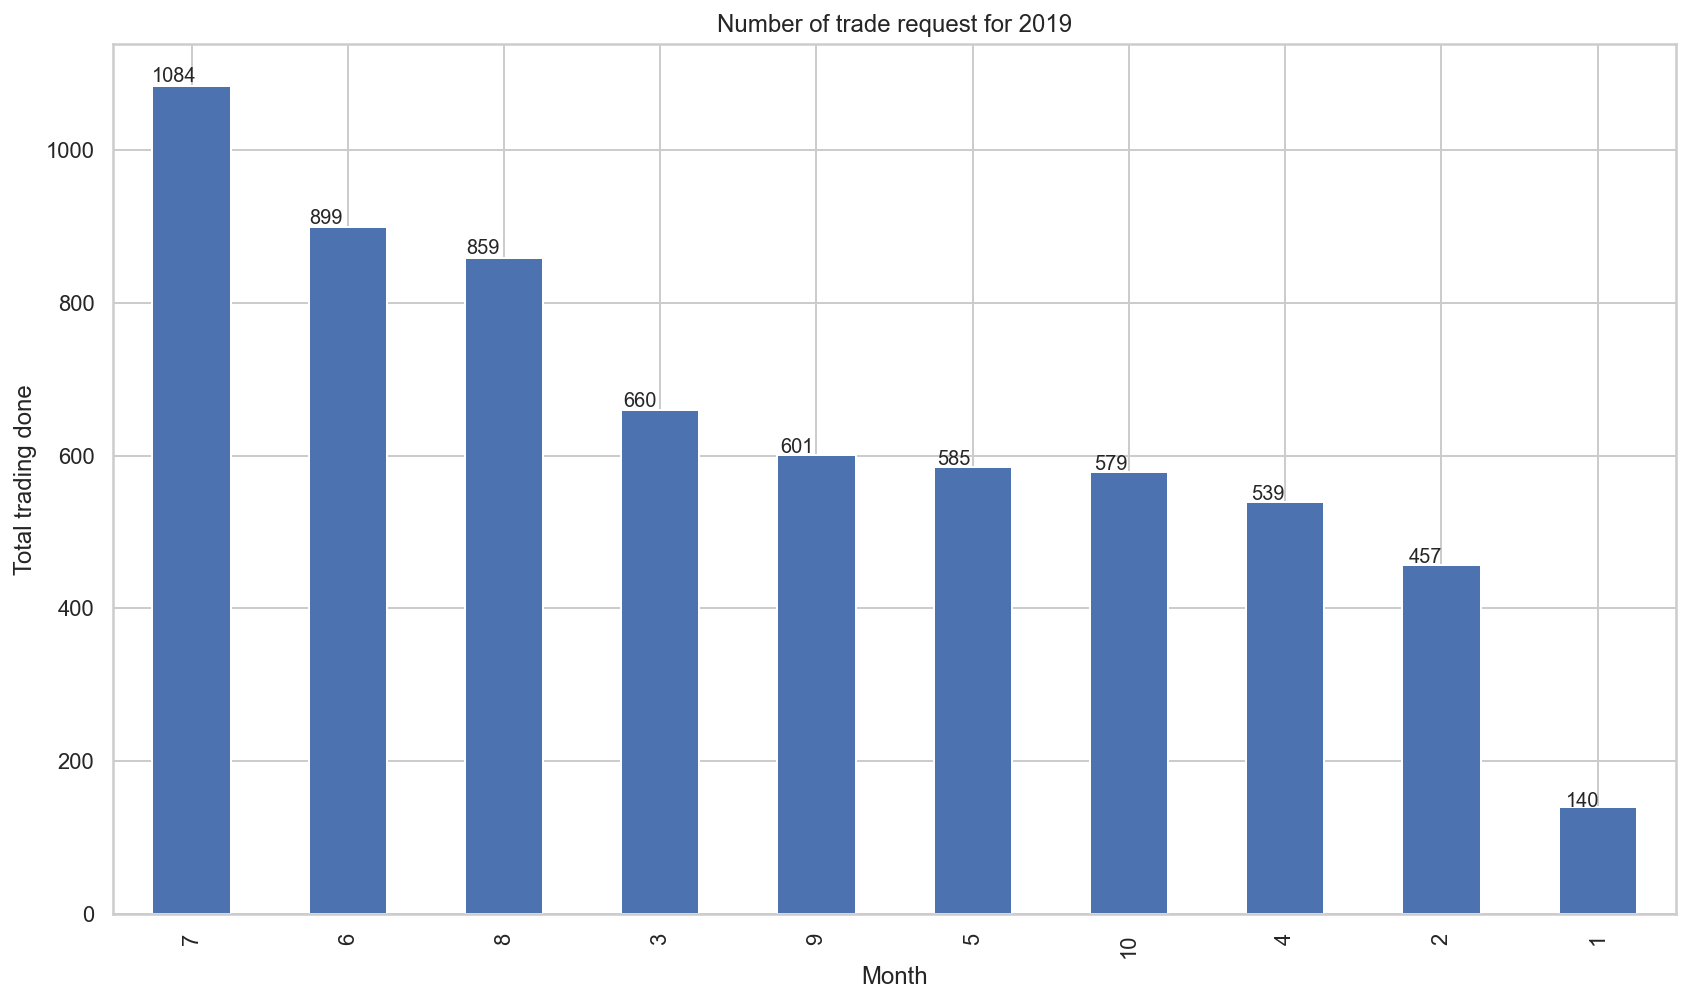

In [45]:
panda_df = df.toPandas()
ax = panda_df['month'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of trade request for 2019")
ax.set_xlabel("Month")
ax.set_ylabel("Total trading done")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

Let us look at month wise request raised by clients, which will give us understanding of clients who are actively trading and should be targeted for more business.

<AxesSubplot:xlabel='month', ylabel='count'>

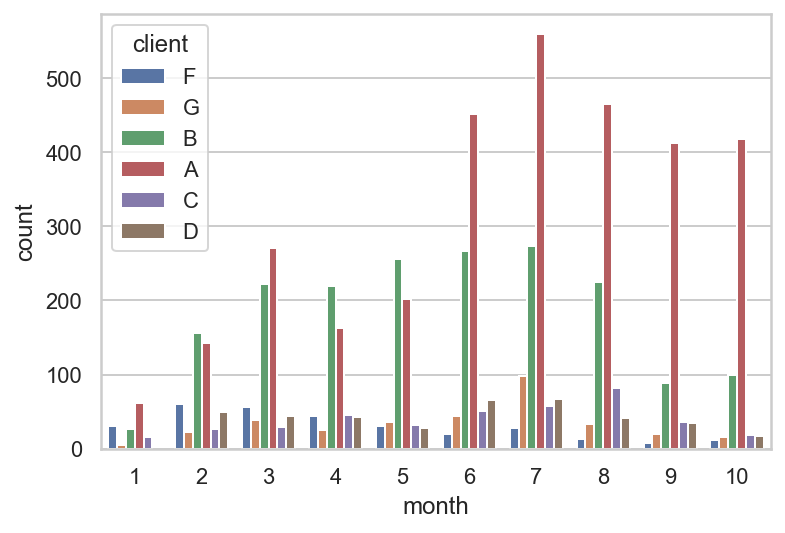

In [46]:
# Split of clients requesting over months
sns.countplot(data=panda_df,x='month',hue='client')

Client activity tracker per month

Split of instruments been traded over time

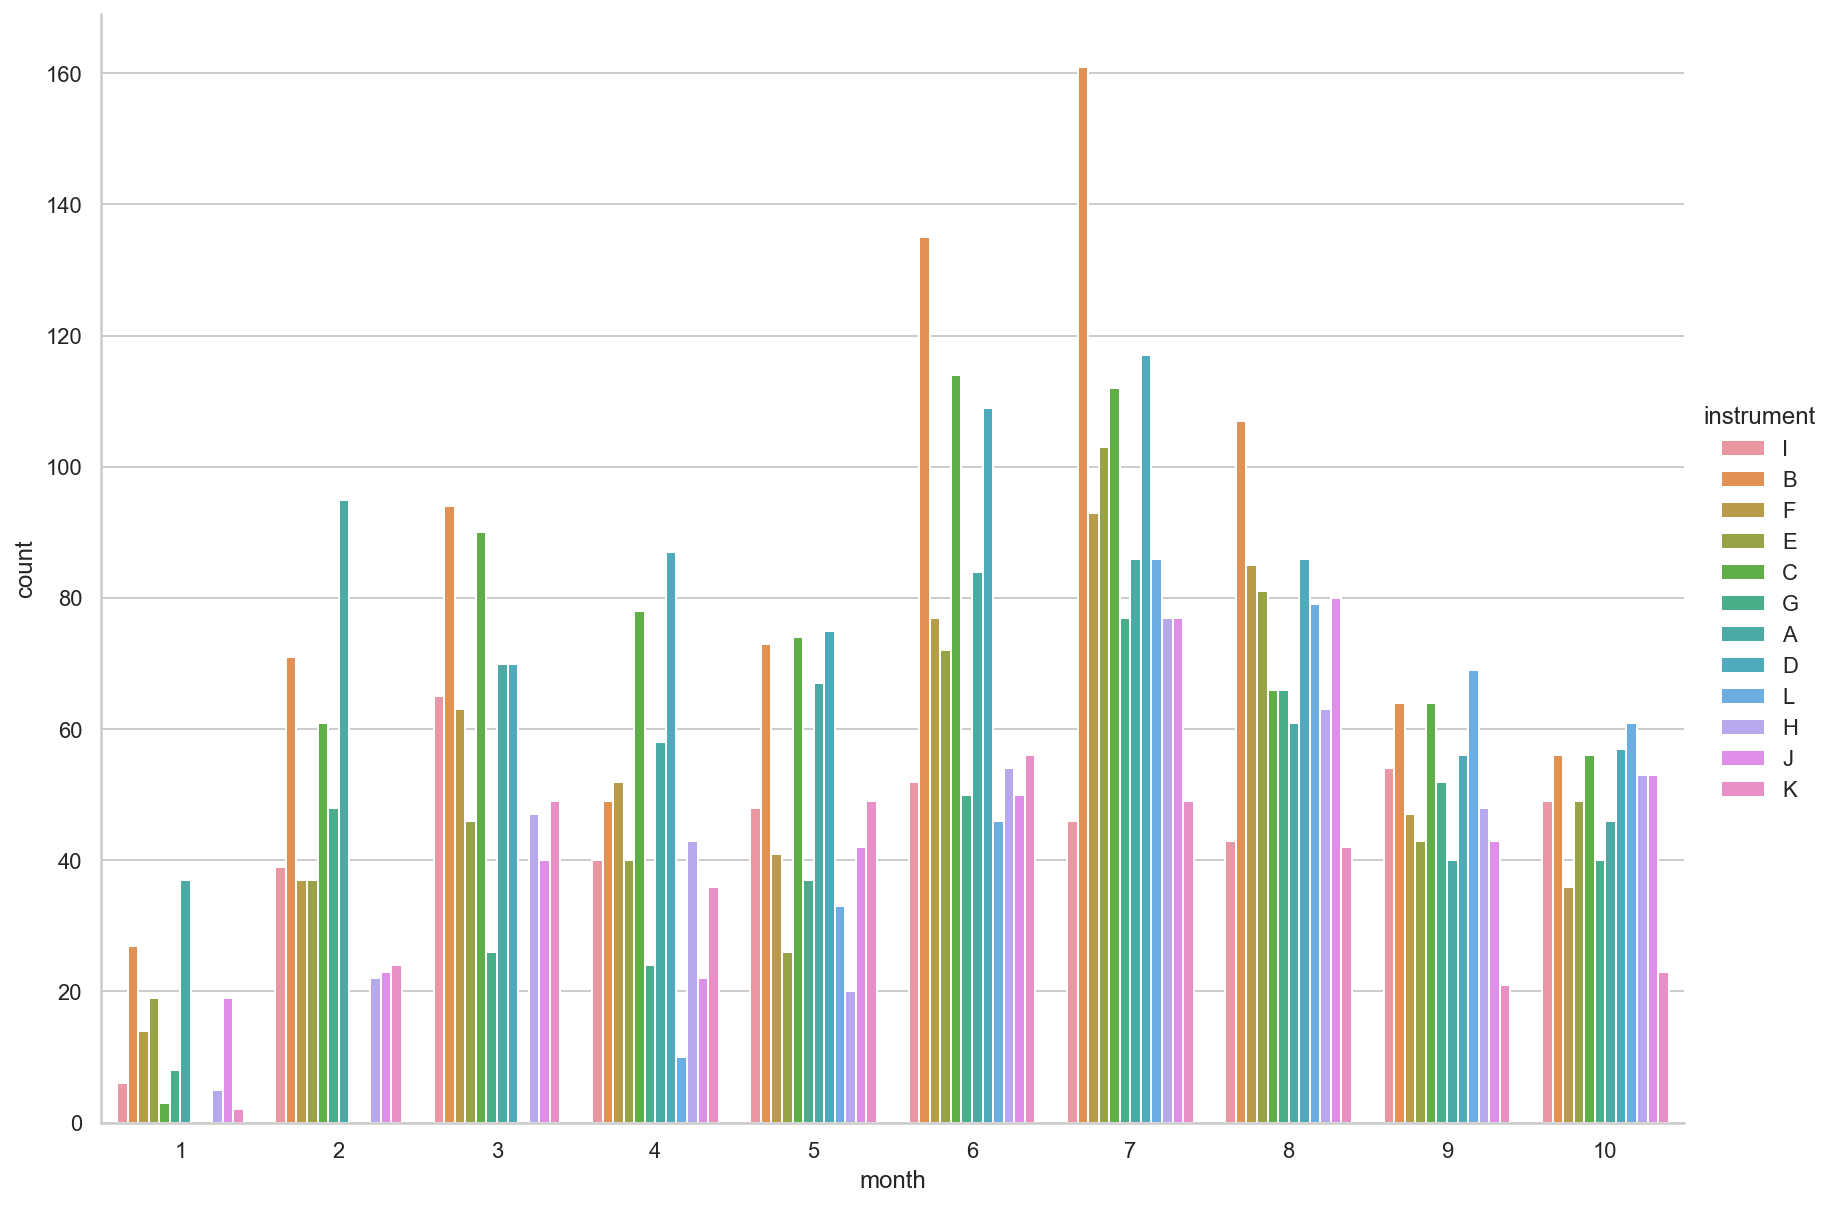

In [47]:
sns.catplot(data=panda_df,kind='count',x='month',hue='instrument',height=8.27, aspect=11.7/8.27)

Profit which was made or could be made on a client over time.

Spread_internal = Profit made

spread_external = Profit could be made

<ipython-input-48-996bbc026bdd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = panda_df.groupby('client')['spread_internal','spread_external'].sum().plot(kind='bar',


Text(0.5, 0, 'client')

Text(0, 0.5, 'Profit made')

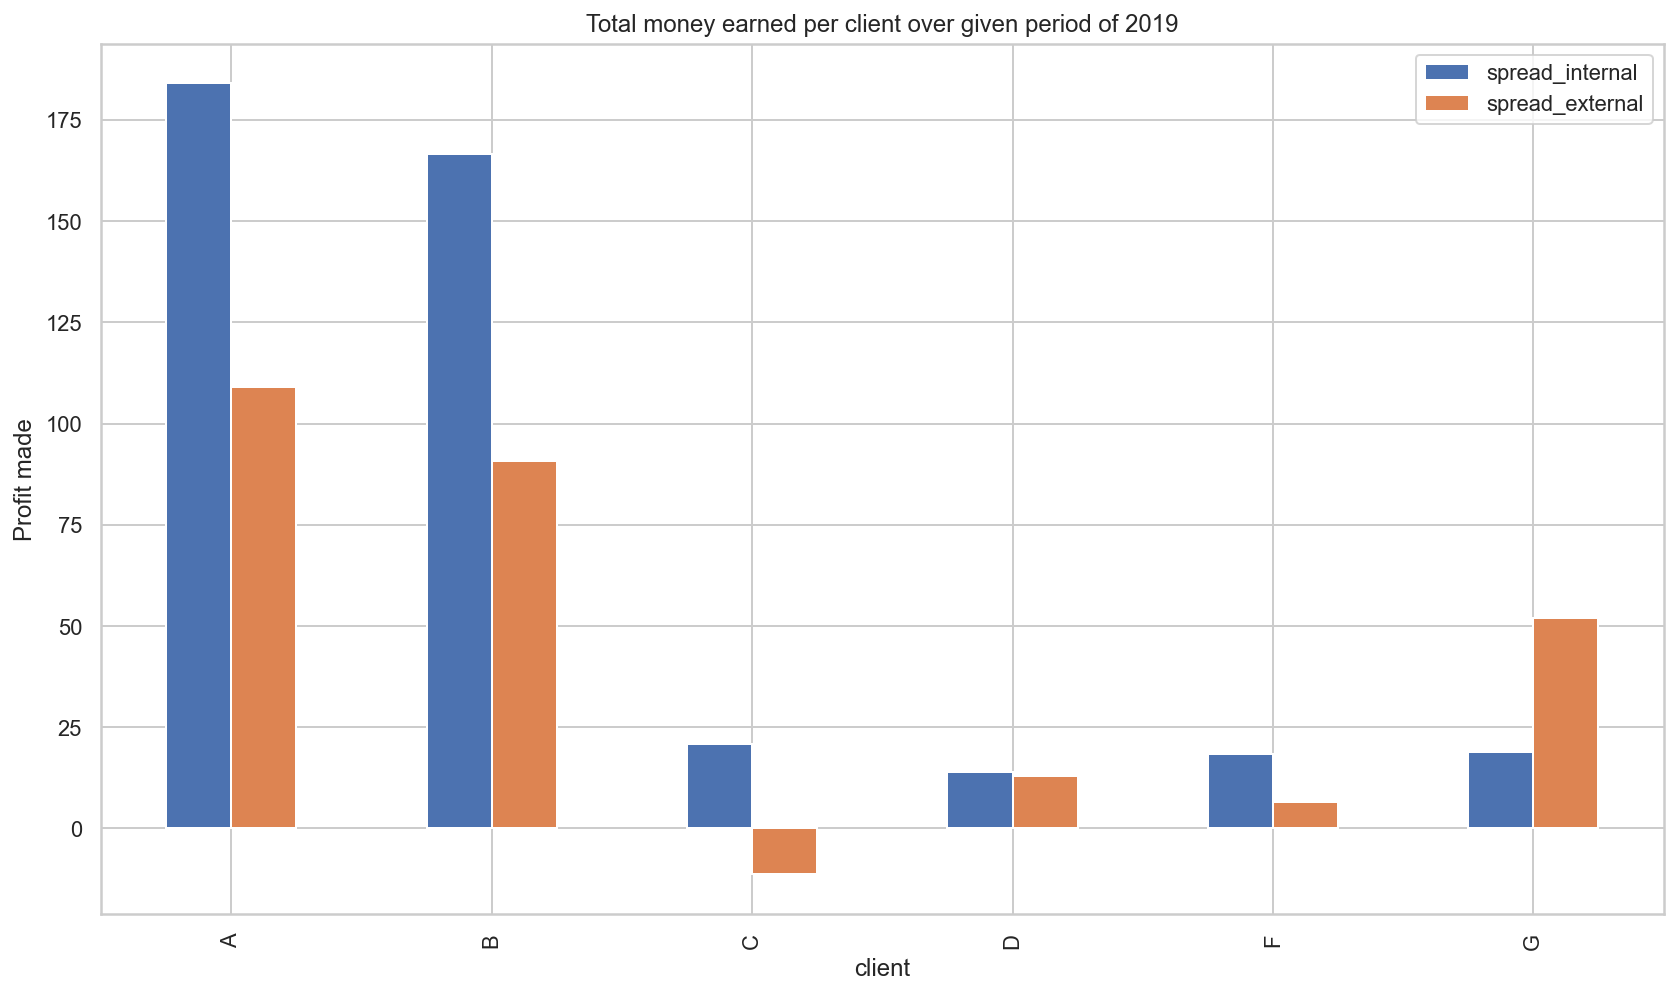

In [48]:
ax = panda_df.groupby('client')['spread_internal','spread_external'].sum().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Total money earned per client over given period of 2019")
ax.set_xlabel("client")
ax.set_ylabel("Profit made")

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='instrument', ylabel='price'>

Text(0.5, 1.0, 'Instrument VS price ratio')

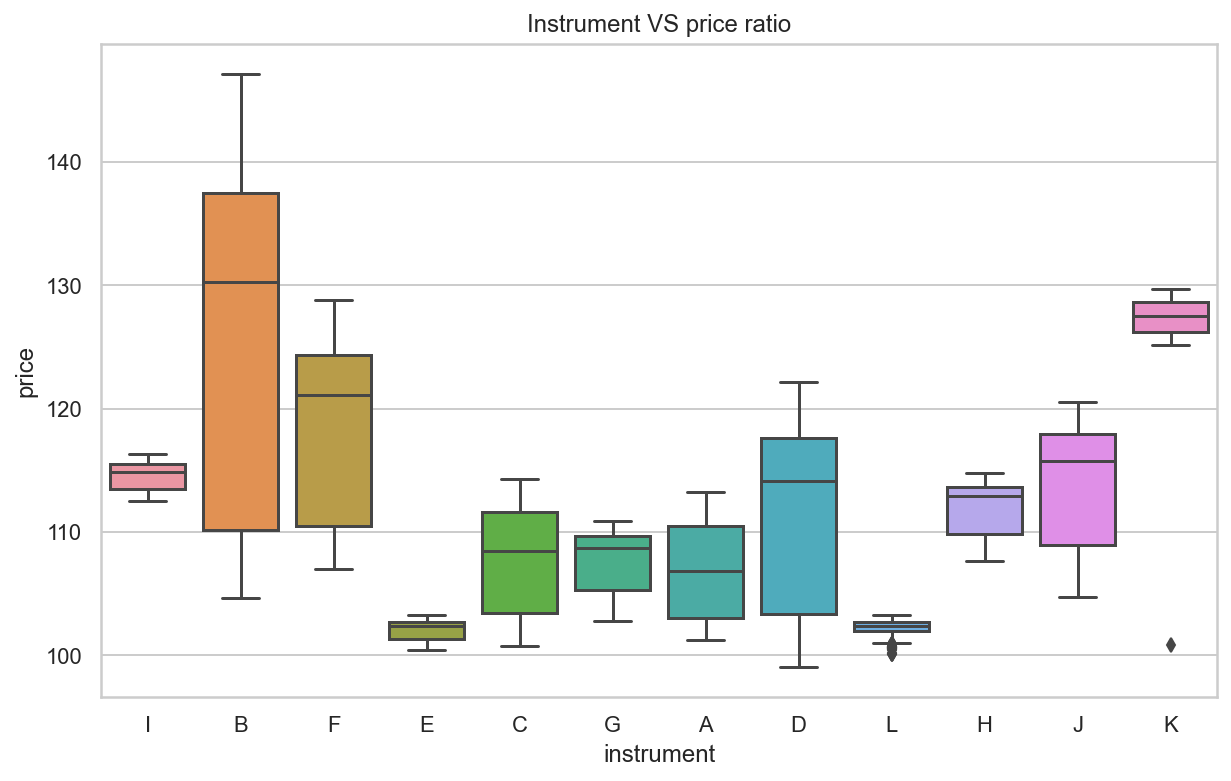

In [49]:
plt.figure(figsize=(10,6))
sns.boxplot(x='instrument', y='price', data=panda_df)
plt.title('Instrument VS price ratio')
plt.show()

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='instrument', ylabel='spread_internal'>

Text(0.5, 1.0, 'Instrument VS profit ratio')

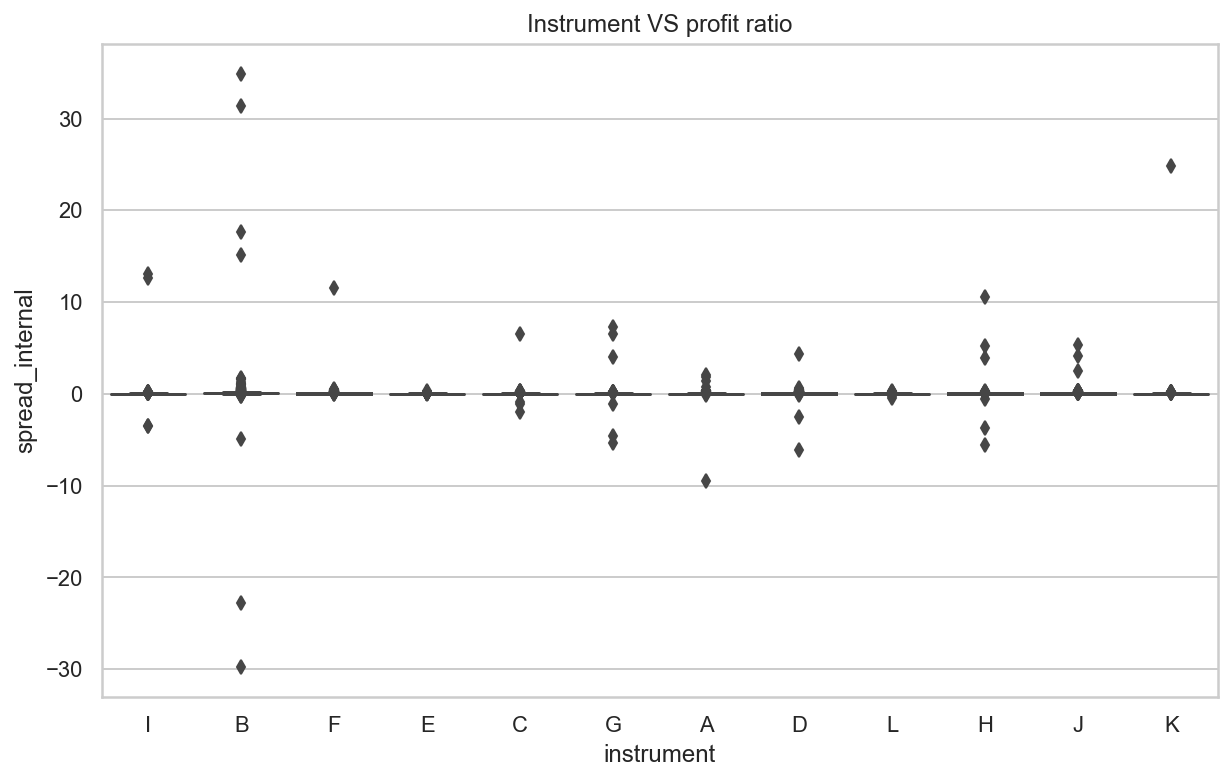

In [50]:
plt.figure(figsize=(10,6))
sns.boxplot(x='instrument', y='spread_internal', data=panda_df)
plt.title('Instrument VS profit ratio')
plt.show()

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='client', ylabel='mid'>

Text(0.5, 1.0, 'client vs mid offered')

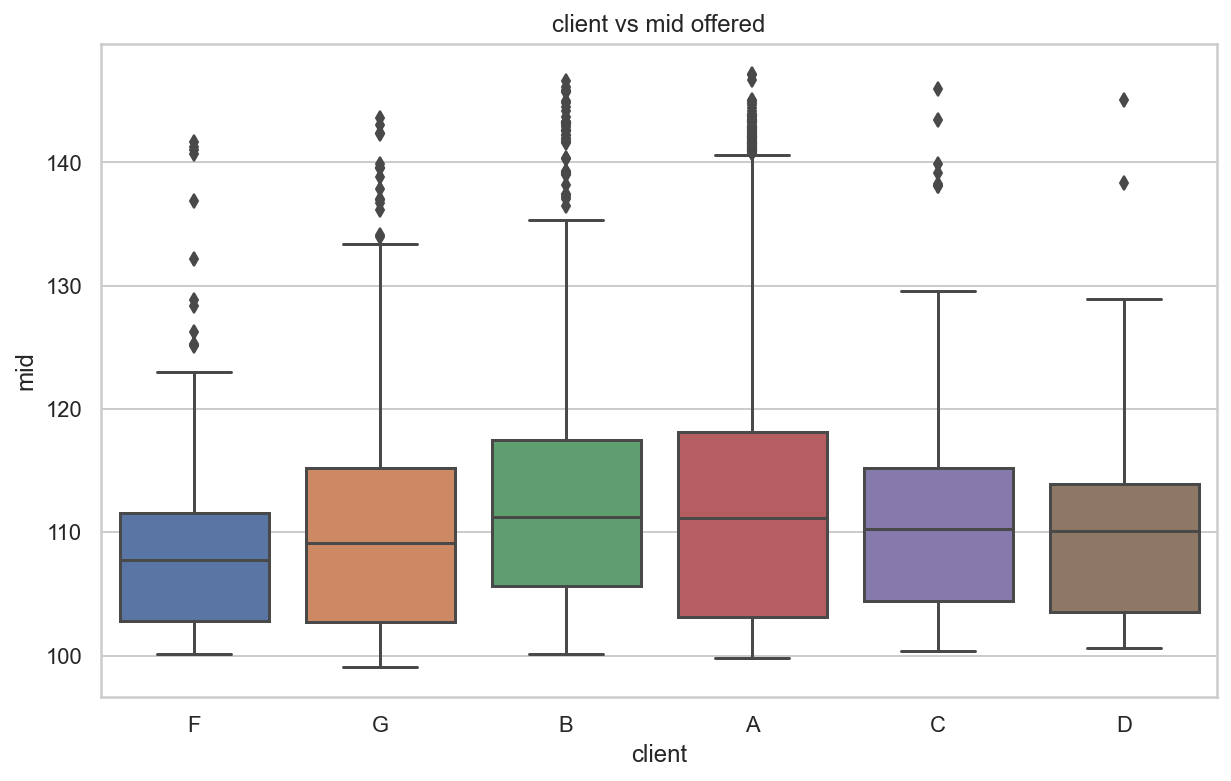

In [51]:
plt.figure(figsize=(10,6))
sns.boxplot(x='client', y='mid', data=panda_df)
plt.title('client vs mid offered')
plt.show()

**Feature Engineering and Model Building**


So far we used spark dataframe available in SPARK SQL for EDA and initial analysis. Now we will be using the SPARK ML library to do feature engineering and model design. 

We will cover the following ML task on SPARK ML here:

**StringIndexer**: Converts string categories to numerical categories.

**Vector Assembler**: Special to Spark API. We will find detail shortly.

**Train-validation split**: Split training and testing data for unbiased evaluation.

**Classification Model**:
Tree-based ensemble methods: Random forest and Gradient boosting.

**Model Evaluation**: Evaluating our model on unseen data to make sure our model is not overfitting or underfitting.


In [52]:
df.show(5)

+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+-----+
|instrument|  DateOnly|client|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|     spread_internal|     spread_external|month|
+----------+----------+------+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+-----+
|         I|2019-01-25|     F|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|      112.88|0.037399999999990996|-0.10099999999999909|    1|
|         B|2019-01-28|     G|106.065|106.1855|   0.5|21.9017|          5|   1|  0|     106.342| 0.12050000000000693|   0.277000000000001|    1|
|         F|2019-01-28|     G|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|     107.586| 0.04999999999999716|0.021000000000000796|    1|
|         E|2019-01-29|     F|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|     100.697| 0.04000000000000625|-0.0750000000

In [53]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,instrument,string
1,DateOnly,string
2,client,string
3,price,double
4,mid,double
5,vol_MM,double
6,dv01,double
7,num_dealers,int
8,side,int
9,won,int


**String Indexer**

We will convert the instrument and client column from string to numeric index. This creates a new column for numeric leaving the original intact. So we will remove them afterward.

In [54]:
stringIndex = StringIndexer(inputCols=['instrument', 'client'], 
                       outputCols=['instrumentNum', 'clientNum'])

stringIndex_model = stringIndex.fit(df)

df1_ = stringIndex_model.transform(df).drop('instrument', 'client','DateOnly')
df1_.show(4)

+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+-----+-------------+---------+
|  price|     mid|vol_MM|   dv01|num_dealers|side|won|mid_external|     spread_internal|     spread_external|month|instrumentNum|clientNum|
+-------+--------+------+-------+-----------+----+---+------------+--------------------+--------------------+-----+-------------+---------+
|112.779|112.7416|   2.0|  6.087|          5|  -1|  0|      112.88|0.037399999999990996|-0.10099999999999909|    1|          7.0|      5.0|
|106.065|106.1855|   0.5|21.9017|          5|   1|  0|     106.342| 0.12050000000000693|   0.277000000000001|    1|          0.0|      4.0|
|107.607| 107.557| 0.975|13.2621|          5|  -1|  0|     107.586| 0.04999999999999716|0.021000000000000796|    1|          4.0|      4.0|
|100.622| 100.582|  0.01| 4.4853|          5|  -1|  0|     100.697| 0.04000000000000625|-0.07500000000000284|    1|          5.0|      5.0|
+-------+--------+--

In [55]:
df1_.printSchema()

root
 |-- price: double (nullable = true)
 |-- mid: double (nullable = true)
 |-- vol_MM: double (nullable = true)
 |-- dv01: double (nullable = true)
 |-- num_dealers: integer (nullable = true)
 |-- side: integer (nullable = true)
 |-- won: integer (nullable = true)
 |-- mid_external: double (nullable = true)
 |-- spread_internal: double (nullable = true)
 |-- spread_external: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- instrumentNum: double (nullable = false)
 |-- clientNum: double (nullable = false)



**What is VectorAssembler?**

In Python's scikit learn API the model takes X and y variable in the separation matrix. The target y is usually a column vector and feature X is a matrix. scikit learn accepts X as a matrix of dataframe directly. But Spark API is different here. First, it requires X and y in a single matrix instead of two for the training data. It accepts X only in the prediction part as it should. And also X should be a vector in each row (see the output below) of the dataframe. In short, we can not directly feed the dataframe in the model. We should do what VectorAssembler does.

In below, inputCols are the feature columns that are doing to be merged to make a vector in each row and outputCol is the name of the merged column. This is the column that Spark ML identifies as the feature column. It is a common practice to rename this as features as Spark ML identifies this name. If its name is different you have to mention column name when fitting model. Then we can select only the feature column and y column.

In [56]:
vec_asmbl = VectorAssembler(inputCols=df1_.drop("won").columns, 
                           outputCol='features')
df1_ = vec_asmbl.transform(df1_).select('features', 'won')
df1_.show(4, truncate=False)

+-----------------------------------------------------------------------------------------------------+---+
|features                                                                                             |won|
+-----------------------------------------------------------------------------------------------------+---+
|[112.779,112.7416,2.0,6.087,5.0,-1.0,112.88,0.037399999999990996,-0.10099999999999909,1.0,7.0,5.0]   |0  |
|[106.065,106.1855,0.5,21.9017,5.0,1.0,106.342,0.12050000000000693,0.277000000000001,1.0,0.0,4.0]     |0  |
|[107.607,107.557,0.975,13.2621,5.0,-1.0,107.586,0.04999999999999716,0.021000000000000796,1.0,4.0,4.0]|0  |
|[100.622,100.582,0.01,4.4853,5.0,-1.0,100.697,0.04000000000000625,-0.07500000000000284,1.0,5.0,5.0]  |0  |
+-----------------------------------------------------------------------------------------------------+---+
only showing top 4 rows



**Train-Validation Split**

Now we split the training data into the train and validation part. We split the data into a 7:3 ratio.

In [57]:
train_df, valid_df = df1_.randomSplit([0.7, 0.3])
train_df.show(4, truncate=False)


+----------------------------------------------------------------------------------------------------+---+
|features                                                                                            |won|
+----------------------------------------------------------------------------------------------------+---+
|[99.069,99.0825,7.5,13.882,5.0,1.0,99.0825,0.013499999999993406,0.013499999999993406,3.0,2.0,4.0]   |1  |
|[99.864,99.8407,2.75,14.0053,5.0,-1.0,99.8407,0.023300000000006094,0.023300000000006094,3.0,2.0,0.0]|0  |
|[99.887,105.9995,11.0,10.8411,2.0,-1.0,105.9995,-6.112499999999997,-6.112499999999997,3.0,2.0,0.0]  |0  |
|[99.947,99.9085,3.0,14.0163,5.0,-1.0,99.9085,0.03849999999999909,0.03849999999999909,3.0,2.0,0.0]   |0  |
+----------------------------------------------------------------------------------------------------+---+
only showing top 4 rows



**Classification Model**

As our problem above is a classification based case where our targe variable is 0 or 1 basically won or not won, we need to select classification based algorithms.

The challenge in our  case is that the training data is **highly imbalanced** as we have very less samples of cases where we have won to ones we have not.

So inorder to handle imbalanced data, we either need to balance it out(undersampling or oversampling) or use algorithm that balances weights using tuning.

For now I will use ensemble technique for modelling but in future would be good to add it on top of that.

**Ensemble Tree**

Currently Spark ML supports two types of ensemble algorithm. Random forest for bagging and gradient boosting for boosting. There is no stacking algorithm available in Spark ML yet. Here we will study both availabel ensemble method both are tree-based methods.

In [58]:
evaluator = MulticlassClassificationEvaluator(labelCol='won', 
                                          metricName='accuracy')

rf = RandomForestClassifier(labelCol='won', 
                           numTrees=100, maxDepth=3)


rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(valid_df)
print('accuracy of Random forest on unseen data: '+str(evaluator.evaluate(rf_pred)))


accuracy of Random forest on unseen data: 0.8895410885805763


#### using pipeline eith grid search and cross validation for selecting best combination

pipeline = Pipeline(stages = [rf])
paramGrid = ParamGridBuilder()\
   .addGrid(rf.maxDepth, [2, 4, 6, 8])\
   .addGrid(rf.minInstancesPerNode, [1, 2,  5, 7])\
   .addGrid(rf.numTrees, [50,100,150,200])\
   .build()

evaluator = MulticlassClassificationEvaluator(labelCol='won', 
                                          metricName='accuracy')

crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluator,
                          numFolds = 10)

cvModel = crossval.fit(train_df)
print(cvModel.bestModel.stages)
cvModel_rf = cvModel.fit(train_df)
cv_rf_pred = cvModel_rf.transform(valid_df)
print('accuracy of tunned Random forest on unseen data: '+str(evaluator.evaluate(cv_rf_pred)))


In [59]:
gb = GBTClassifier(labelCol='won', maxIter=75, maxDepth=3)

gb_model = gb.fit(train_df)
gb_pred = gb_model.transform(valid_df)
print('accuracy of Gradient Boosting on unseen data: '+str(evaluator.evaluate(gb_pred)))


accuracy of Gradient Boosting on unseen data: 0.8922091782283885


We have trained both our bagging and boosting models using training data and in terms on pure accuracy, we can see that boosting performs slightly better than bagging.


**Model Evaluation:**

As mentioned above, even if we score a 100% accuracy it wont be impressive as our training dataset is highly imbalanced. So our trained model is going to be more  biased towards majority class instead of minority class. So the best way to evaluate our model is using different evaluation metrics like F1 score, precision, recall per class and then confusion metric.

In [60]:
prediction_scores = {'random_forest':rf_pred,'gradient_boosting':gb_pred}

for pred in prediction_scores:
  print('PRINTING RESULTS FOR: '+ str(pred))
  evaluator = BinaryClassificationEvaluator(labelCol='won')
  print("Test Area Under ROC: " + str(evaluator.evaluate(prediction_scores[pred], {evaluator.metricName: "areaUnderROC"})))
  evaluator = MulticlassClassificationEvaluator(labelCol='won', 
                                          metricName='f1')
  print("F1-SCORE: "+str(evaluator.evaluate(prediction_scores[pred])))
  evaluator = MulticlassClassificationEvaluator(labelCol='won', 
                                          metricName='precisionByLabel')
  print("PRECISION_BY_LABEL-SCORE: "+str(evaluator.evaluate(prediction_scores[pred])))
  evaluator = MulticlassClassificationEvaluator(labelCol='won', 
                                          metricName='recallByLabel')
  print("RECALL_BY_LABEL-SCORE: "+str(evaluator.evaluate(prediction_scores[pred])))
  y_true = prediction_scores[pred].select(['won']).collect()
  y_pred = prediction_scores[pred].select(['prediction']).collect()
  print('PRINTING CLASSIFICATION REPORT...................')
  print(classification_report(y_true, y_pred))
  print('PRINTING CONFUSION MATRIX...................')
  print(confusion_matrix(y_true,y_pred))




PRINTING RESULTS FOR: random_forest
Test Area Under ROC: 0.7538081409432527
F1-SCORE: 0.8396026001133292
PRECISION_BY_LABEL-SCORE: 0.8893048128342246
RECALL_BY_LABEL-SCORE: 1.0
PRINTING CLASSIFICATION REPORT...................
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1663
           1       1.00      0.02      0.04       211

    accuracy                           0.89      1874
   macro avg       0.94      0.51      0.49      1874
weighted avg       0.90      0.89      0.84      1874

PRINTING CONFUSION MATRIX...................
[[1663    0]
 [ 207    4]]
PRINTING RESULTS FOR: gradient_boosting
Test Area Under ROC: 0.8032363142040422
F1-SCORE: 0.8533674243762762
PRECISION_BY_LABEL-SCORE: 0.8955062263129399
RECALL_BY_LABEL-SCORE: 0.994588093806374
PRINTING CLASSIFICATION REPORT...................
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1663
           1       0

As we see above, Gradient boosting performs much better than Random Forest and it is evident in the confusion matrix of both.

However, there is alot more to improve from here.....


**Future Work:**

As we part of POC baseline model we produced a model that predicts if a given trade will be won or not.

However inorder to put this model in production there will be few more changes that I would make, before making it as final version.

1. Handling imbalanced data before training the model if possible.

2. Trying more robust models that perform well on imbalanced data.

3. Adding pipeline to run sequence of tasks:  StringIndexer, VectorAssembler, and ML model training-evaluation.

4. Run Grid-Search and cross validation for hyperparameter tuning.